# Imports

In [1]:
import cvxpy
import matplotlib.pyplot as plt
import numpy
import numpy.random
from scipy.optimize import least_squares, shgo, direct
from tqdm.notebook import tqdm

%run unit_exponentials.ipynb

# Useful mathematical functions

In [2]:
def powermean(xx,mean_power=1.0):
    #print(f"xx:{xx}, mean_power:{mean_power}")
    average = numpy.average(numpy.power(xx,mean_power))
    return numpy.sign(average)*numpy.power(numpy.abs(average),1.0/mean_power)

In [113]:
def penalize_negative_exp(xx,exponent=1.0):
    return numpy.exp(-xx*exponent)

# Hyperparameters

In [2]:
# Number of unit exponentials to add
n = 7
#n = 25

# Boundaries of multiplier arguments
min_k = 1.25
max_k = 2.25
#min_k = 1.01
#max_k = 1.25

# Maximum weight multiplier
r = 3

# Initial value for weights
default_w = 0.5

# Initial value for k_0
default_initial_k = 0.5

# Initial value for other k_j
default_k = 2
#default_k = 1.1

# Sums of unit exponentials

In [3]:
# params should be an array [k_0,w_1,k_1,w_2,...,w_n]
def uexp_sum(params, n=n, **kwargs):
    k0 = params[0]
    cur_t = k0
    cur_w = params[1]
    uexps = [uexp(cur_t)]
    ww = [cur_w]

    for i in range(1,n):
        cur_k = params[2*i]
        cur_t = cur_t * cur_k
        uexps.append(uexp(cur_t))
        
        cur_w = params[2*i+1]
        ww.append(cur_w)

    def uexp_sum_f(x):
        result = 0.0
        for i in range(n):
            w = ww[i]
            uexp_f = uexps[i]

            result += w * uexp_f(x)

        return result

    return uexp_sum_f

In [4]:
def uexp_sum_str(params, n=n, **kwargs):
    k0 = params[0]
    cur_t = k0
    cur_w = params[1]

    result = f"{cur_w:.2f}uexp({cur_t:.2f})"

    for i in range(1,n):
        cur_k = params[2*i]
        cur_t = cur_t * cur_k
        cur_w = params[2*i+1]
        result += f" + {cur_w:.2f}uexp({cur_t:.2f})"

    return result

# Least squares fitting

In [5]:
def residuals_absolutely_monotonic_fit_parametric(params, xx, yy, **kwargs):            
    f = uexp_sum(params, **kwargs)

    fxx = f(xx)
    
    return yy - fxx
    
def absolutely_monotonic_fit_parametric(xx, yy, n=n,min_k=min_k,max_k=max_k,default_initial_k=default_initial_k,default_k=default_k,default_w=default_w,r=r,**kwargs):        
    max_y = numpy.max(yy)
    
    min_bounds = [0,0]
    max_bounds = [max_k,r*max_y]
    initial_params = [default_initial_k,default_w]
    
    for i in range(1,n):
        min_bounds.append(min_k)
        min_bounds.append(0)
        max_bounds.append(max_k)
        max_bounds.append(r*max_y)
        initial_params.append(default_k)
        initial_params.append(default_w)
    
    residuals_lambda = lambda params:residuals_absolutely_monotonic_fit_parametric(params,xx,yy,n=n,**kwargs)    
    
    result = least_squares(residuals_lambda, initial_params, bounds=(min_bounds,max_bounds))

    return result.x

# Sum of positive monomials

## Discrete differences

In [20]:
# Returns an array of arrays.
# Position 0 is the degree 0 differences (actual values) - n elements
# Position 1 is the degree 1 differences (slope between subsequent points) - n-1 elements
# Position 2 is the degree 2 differences (curvature between 3 subsequent points / slope between 2 slopes) - n-2 elements
# etc.
def calculate_differences(xx, yy, max_degree):
    n = len(xx)
    max_degree = min(max_degree, n-1)

    result = [yy]
    for i in range(max_degree):
        prev_yy = result[-1]
        new_differences = numpy.array([(prev_yy[j+1] - prev_yy[j])/(xx[i+j+1]-xx[i+j]) for j in range(len(prev_yy)-1)])
        result.append(new_differences)

    return result

def minimum_difference(xx, yy, max_degree):
    differences = calculate_differences(xx,yy,max_degree)
    return numpy.min([numpy.min(i_diff) for i_diff in differences])

## Monomials

In [84]:
max_monomial_coef = 20
#diff_margin = 999999999

In [109]:
def monomial(xx, degree, coef):
    return coef*numpy.power(xx,degree)

# Returns the optimal coefficient (using a powermean of differences)
# max_degree is the maximum degree of differences to evaluate
# diff_margin is the margin to allow differences to go into the negative. Currently an absolute value.
def optimize_coef_monomial(xx, yy, degree, max_monomial_coef=max_monomial_coef, **kwargs):
    def ff_coef(coef):
        return monomial(xx,degree,coef)

    def deltas_coef(coef):
        return yy - ff_coef(coef)   
        
    def obj_func(coef):
        deltas = deltas_coef(coef)   
        penalty_negative = penalize_negative_exp(deltas)
        abs_deltas = numpy.abs(deltas)
        return float(powermean(abs_deltas+penalty_negative,**kwargs))
    
    bounds = [(0,max_monomial_coef)]
    
    result = shgo(obj_func, bounds)

    if result.x is None or not result.success:
        return 0.0, obj_func(0.0)

    return result.x[0], result.fun

In [103]:
max_polynomial_degree = 15
max_polynomial_degree_exponent = 8

In [88]:
def candidate_degrees_all(max_polynomial_degree=max_polynomial_degree):
    return range(1,max_polynomial_degree+1)

def candidate_degrees_exponential(max_polynomial_degree_exponent=max_polynomial_degree_exponent):
    return [2**i for i in range(max_polynomial_degree_exponent)]

def discrete_optimize_scan(obj_fun,candidates):
    min_value = numpy.inf
    min_candidate = None
    for candidate in candidates:
        value = obj_fun(candidate)
        #print(f"candidate:{candidate}, value:{value}")
        if value < min_value:
            min_candidate = candidate
            min_value = value

    return min_candidate,min_value

In [105]:
def optimize_degree_monomial(xx, yy, candidate_degrees=candidate_degrees_exponential, **kwargs):    
    bounds = [(1,max_polynomial_degree)]
    mean_yy = numpy.average(yy)    

    def obj_func(degree):
        coef, diff = optimize_coef_monomial(xx, yy, degree, **kwargs)

        return diff
        
    degree,diff = discrete_optimize_scan(obj_func,candidate_degrees())        
    coef, diff = optimize_coef_monomial(xx, yy, degree, **kwargs)

    #print(f"degree: {degree}, coef: {coef}, diff: {diff}")
    return degree, coef, diff

In [106]:
initial_reserve = 0.4
reserve_factor = 0.95
min_coef = 0.001
mean_power = 2

In [111]:
def decompose_monomial_sum(xx, yy, initial_reserve = initial_reserve, reserve_factor = reserve_factor, mean_power=mean_power, min_coef=min_coef, **kwargs):
    mean_yy = numpy.average(yy)
    
    result = {}
    cur_reserve = initial_reserve

    coef = 1
    while coef > min_coef:
        degree, coef, diff = optimize_degree_monomial(xx, yy, mean_power=mean_power)        
        #print(f"degree: {degree}, coef: {coef}, diff: {diff}")
        
        cur_factor = 1.0 - cur_reserve
        
        cur_coef = result.get(degree,0)
        cur_coef += cur_factor*coef

        result[degree] = cur_coef

        yy = yy - monomial(xx, degree, coef*cur_factor)
        cur_reserve *= reserve_factor               

    return result

In [92]:
def monomial_sum(xx,params):
    result = numpy.zeros_like(xx)
    for degree,coef in params.items():
        result += monomial(xx,degree,coef)

    return result

def monomial_sum_str(params):
    result = ""
    for degree,coef in params.items():
        result += f" + {coef}x^{degree}"

    return result

In [93]:
min_final_coef_prop=0.001

In [94]:
def filter_monomial_sum(sum_dict,min_final_coef_prop=min_final_coef_prop):
    max_coef = 0.0
    for degree,coef in sum_dict.items():
        if coef > max_coef:
            max_coef = coef

    if max_coef == 0.0:
        return sum_dict
        
    result = {}
    for degree,coef in sum_dict.items():
        if coef/max_coef > min_final_coef_prop:
            result[degree] = coef

    return result

In [95]:
reps = 3
for i in range(reps):
    n = 20
    xx = numpy.sort(numpy.random.rand(n))    
    mean_power = 2
    
    yy = 0.75*(numpy.exp(xx)-1)+3.5*xx*xx+0.24*(numpy.exp(xx*xx)-1)    
    
    result = filter_monomial_sum(decompose_monomial_sum(xx, yy, mean_power=mean_power))

    print(result)    
    print(yy)
    print(monomial_sum(xx,result))
    print("---")

{2: 3.1745962294905428}
[0.00739398 0.09338593 0.13757952 0.28252565 0.28928243 0.32913447
 0.56207578 0.65826596 0.70237648 0.92448942 1.44097293 1.47906214
 1.62152283 2.13389617 2.14072587 2.49817989 2.54263232 2.79593079
 3.10483788 3.17459456]
[2.79085933e-04 2.28697402e-02 4.05704112e-02 1.09661120e-01
 1.13141628e-01 1.33996199e-01 2.63717030e-01 3.19855462e-01
 3.45943953e-01 4.79790305e-01 8.00740034e-01 8.24734992e-01
 9.14734464e-01 1.24060443e+00 1.24496210e+00 1.47322275e+00
 1.50161853e+00 1.66336949e+00 1.86034326e+00 1.90475673e+00]
---
{2: 3.1244085341971632}
[0.01201955 0.04532593 0.05865658 0.06827945 0.09104759 0.19201373
 0.31504345 0.47210464 0.66387745 0.69499695 1.05744691 1.08573909
 1.11908651 1.43224059 2.01749805 2.52034544 3.11157808 3.2086642
 3.2867755  4.70975552]
[6.86258345e-04 7.15427592e-03 1.08923889e-02 1.38704139e-02
 2.16580314e-02 6.39771491e-02 1.24560952e-01 2.09002829e-01
 3.18054345e-01 3.36166107e-01 5.52527944e-01 5.69728675e-01
 5.9004605

# Evaluation

In [50]:
def generate_sample(f,number_samples=200,gaussian_noise_std_mult=0,**kwargs):       
    xx = numpy.sort(numpy.random.random_sample(number_samples))
    yy = f(xx)

    # Add noise
    if gaussian_noise_std_mult > 0:
        noise = numpy.random.normal(scale=gaussian_noise_std_mult*f(1),size=number_samples)        
    else:
        noise = 0

    return (xx,yy+noise)

number_samples_test=200
# Returns a dictionary with entries:
#  - xx
#  - yy
#  - params
#  - fit_nmse
#  - source_nmse
def evaluate_absolutely_monotonic_fit(f,number_samples,number_samples_test=number_samples_test,**kwargs):
    (xx,yy) = generate_sample(f,number_samples=number_samples,**kwargs)

    params = absolutely_monotonic_fit_parametric(xx,yy,**kwargs)

    fit_residuals = residuals_absolutely_monotonic_fit_parametric(params, xx, yy, **kwargs)

    fit_mse = numpy.average(fit_residuals * fit_residuals)
    fit_nmse = fit_mse/f(1)

    xx2 = numpy.linspace(0,1,number_samples_test)
    yy2 = f(xx2)
    source_residuals = residuals_absolutely_monotonic_fit_parametric(params, xx2, yy2, **kwargs)

    source_mse = numpy.average(source_residuals * source_residuals)
    source_nmse = source_mse/f(1)

    return {"xx": xx, "yy": yy, "params":params, "fit_nmse":fit_nmse, "source_nmse":source_nmse}

def evaluate_monomial_sum_fit(f,number_samples,number_samples_test=number_samples_test,**kwargs):
    (xx,yy) = generate_sample(f,number_samples=number_samples,**kwargs)

    params = filter_monomial_sum(decompose_monomial_sum(xx, yy, **kwargs))

    fit_residuals = yy - monomial_sum(xx,params)

    fit_mse = numpy.average(fit_residuals * fit_residuals)
    fit_nmse = fit_mse/f(1)

    xx2 = numpy.linspace(0,1,number_samples_test)
    yy2 = f(xx2)
    source_residuals = yy2 - monomial_sum(xx2,params)

    source_mse = numpy.average(source_residuals * source_residuals)
    source_nmse = source_mse/f(1)

    return {"xx": xx, "yy": yy, "params":params, "fit_nmse":fit_nmse, "source_nmse":source_nmse}

In [51]:
def plot_absolutely_monotonic_fit(f, f_desc, params, xx, yy, **kwargs):    
    oo = numpy.linspace(0,1,200)
    
    original_ff = f(oo)

    fitted_f = uexp_sum(params,**kwargs)
    fitted_ff = fitted_f(oo)
    
    plt.plot(oo,original_ff,c="c",linestyle="dotted",alpha=1,label=f_desc)
    plt.plot(oo,fitted_ff,c="r",linestyle="dashed",alpha=1,label=uexp_sum_str(params,**kwargs))
    plt.scatter(xx,yy,c="k",alpha=0.1,marker="x",label="Fit to sampled points")   

def plot_monomial_sum_fit(f, f_desc, params, xx, yy, **kwargs):    
    oo = numpy.linspace(0,1,200)
    
    original_ff = f(oo)

    fitted_ff = monomial_sum(oo,params)
    
    plt.plot(oo,original_ff,c="c",linestyle="dotted",alpha=1,label=f_desc)
    plt.plot(oo,fitted_ff,c="r",linestyle="dashed",alpha=1,label=monomial_sum_str(params,**kwargs))
    plt.scatter(xx,yy,c="k",alpha=0.1,marker="x",label="Fit to sampled points")   

In [52]:
# Using cvxpy
def cvxpy_fit(f, xx, yy, number_samples_test=number_samples_test,**kwargs):
    l = len(xx)
    ff_var = cvxpy.Variable(l)

    objective = cvxpy.Minimize(cvxpy.sum_squares(ff_var - yy))

    constraints = [
        ( (ff_var[i+2] - ff_var[i+1]) / (xx[i+2] - xx[i+1]) -
          (ff_var[i+1] - ff_var[i]) / (xx[i+1] - xx[i]) ) >= 0
        for i in range(l - 2)
    ]

    problem = cvxpy.Problem(objective, constraints)
    problem.solve()

    ff = ff_var.value

    fit_residuals = ff-yy

    fit_mse = numpy.average(fit_residuals * fit_residuals)
    fit_nmse = fit_mse/f(1)

    xx2 = numpy.linspace(0,1,number_samples_test)
    yy2 = f(xx2)
    ff2 = numpy.interp(xx2,xx,ff)
    source_residuals = ff2-yy2

    source_mse = numpy.average(source_residuals * source_residuals)
    source_nmse = source_mse/f(1)

    return {"xx": xx, "yy":yy, "ff":ff, "fit_nmse":fit_nmse, "source_nmse":source_nmse}

def plot_cvxpy_fit(f, f_desc, xx, ff, **kwargs):    
    plt.plot(xx,ff,c="y",linestyle="dashdot",alpha=1,label="Convex fit")

In [53]:
number_tests = 100
def absolutely_monotonic_fit_many(f,number_samples,number_tests=number_tests,**kwargs):
    results = []
    #for i in tqdm(range(number_tests)):
    for i in range(number_tests):
        result = evaluate_absolutely_monotonic_fit(f,number_samples,**kwargs)

        results.append(result)

        if i % 10 == 9:
            print(f"{i+1} tests completed")

    results_source_nmse = numpy.array([result["source_nmse"] for result in results])

    max_source_nmse = numpy.max(results_source_nmse)
    avg_source_nmse = numpy.average(results_source_nmse)
    avg_diffs = numpy.abs(results_source_nmse - avg_source_nmse)
    min_avg_diff = numpy.min(avg_diffs)

    max_result = [result for result in results if result["source_nmse"] == max_source_nmse][0]
    avg_result = [result for result in results if numpy.abs(result["source_nmse"]-avg_source_nmse) == min_avg_diff][0]

    return {"max_source_nmse":max_source_nmse, "avg_source_nmse":avg_source_nmse, "avg_result":avg_result, "worst_result":max_result}

number_tests = 100
def monomial_sum_fit_many(f,number_samples,number_tests=number_tests,**kwargs):
    results = []
    #for i in tqdm(range(number_tests)):
    for i in range(number_tests):
        result = evaluate_monomial_sum_fit(f,number_samples,**kwargs)

        results.append(result)

        if i % 10 == 9:
            print(f"{i+1} tests completed")

    results_source_nmse = numpy.array([result["source_nmse"] for result in results])

    max_source_nmse = numpy.max(results_source_nmse)
    avg_source_nmse = numpy.average(results_source_nmse)
    avg_diffs = numpy.abs(results_source_nmse - avg_source_nmse)
    min_avg_diff = numpy.min(avg_diffs)

    max_result = [result for result in results if result["source_nmse"] == max_source_nmse][0]
    avg_result = [result for result in results if numpy.abs(result["source_nmse"]-avg_source_nmse) == min_avg_diff][0]

    return {"max_source_nmse":max_source_nmse, "avg_source_nmse":avg_source_nmse, "avg_result":avg_result, "worst_result":max_result}

In [54]:
def plot_full_result_absolutely_monotonic_fit(fit_function, function_desc,
                                              number_samples, number_samples_test, gaussian_noise_std_mult,
                                              result):
    params = result["params"]
    xx = result["xx"]
    yy = result["yy"]
    fit_nmse = result["fit_nmse"]
    source_nmse = result["source_nmse"]
    
    result_cvxpy = cvxpy_fit(fit_function,
                             xx,
                             yy,
                             number_samples_test=number_samples_test)
    
    ff_cvxpy = result_cvxpy["ff"]
    fit_nmse_cvxpy = result_cvxpy["fit_nmse"]
    source_nmse_cvxpy = result_cvxpy["source_nmse"]                        
    
    
    if gaussian_noise_std_mult == 0:
        plot_title = f"Absolutely monotonic fit for {function_desc} (N={number_samples})\n" +\
                        f"Fit NMSE={fit_nmse:.2e}, Source NMSE={source_nmse:.2e}\n" +\
                        f"cvxpy Fit NMSE={fit_nmse_cvxpy:.2e}, cvxpy Source NMSE={source_nmse_cvxpy:.2e}\n"
    else:
        plot_title = f"Absolutely monotonic fit for {function_desc} (N={number_samples}, gaussian noise std={gaussian_noise_std_mult:.2f})\n" +\
                        f"Fit NMSE={fit_nmse:.2e}, Source NMSE={source_nmse:.2e}\n" +\
                        f"cvxpy Fit NMSE={fit_nmse_cvxpy:.2e}, cvxpy Source NMSE={source_nmse_cvxpy:.2e}\n"
        
    plot_absolutely_monotonic_fit(fit_function,function_desc,params,xx,yy)
    plot_cvxpy_fit(fit_function,function_desc,xx,ff_cvxpy)
    
    ax = plt.gca()
    ax.set_xlim([0,1])
    
    plt.title(plot_title)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fontsize="x-small")
        
    plt.show()

def plot_full_result_monomial_sum_fit(fit_function, function_desc,
                                              number_samples, number_samples_test, gaussian_noise_std_mult,
                                              result):
    params = result["params"]
    xx = result["xx"]
    yy = result["yy"]
    fit_nmse = result["fit_nmse"]
    source_nmse = result["source_nmse"]
    
    result_cvxpy = cvxpy_fit(fit_function,
                             xx,
                             yy,
                             number_samples_test=number_samples_test)
    
    ff_cvxpy = result_cvxpy["ff"]
    fit_nmse_cvxpy = result_cvxpy["fit_nmse"]
    source_nmse_cvxpy = result_cvxpy["source_nmse"]                        
    
    
    if gaussian_noise_std_mult == 0:
        plot_title = f"Absolutely monotonic polynomial fit for {function_desc} (N={number_samples})\n" +\
                        f"Fit NMSE={fit_nmse:.2e}, Source NMSE={source_nmse:.2e}\n" +\
                        f"cvxpy Fit NMSE={fit_nmse_cvxpy:.2e}, cvxpy Source NMSE={source_nmse_cvxpy:.2e}\n"
    else:
        plot_title = f"Absolutely monotonic polynomial fit for {function_desc} (N={number_samples}, gaussian noise std={gaussian_noise_std_mult:.2f})\n" +\
                        f"Fit NMSE={fit_nmse:.2e}, Source NMSE={source_nmse:.2e}\n" +\
                        f"cvxpy Fit NMSE={fit_nmse_cvxpy:.2e}, cvxpy Source NMSE={source_nmse_cvxpy:.2e}\n"
        
    plot_monomial_sum_fit(fit_function,function_desc,params,xx,yy)
    plot_cvxpy_fit(fit_function,function_desc,xx,ff_cvxpy)
    
    ax = plt.gca()
    ax.set_xlim([0,1])
    
    plt.title(plot_title)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fontsize="x-small")
        
    plt.show()

## Evaluated functions

In [115]:
f1_desc = "e^x - normalized"
f1_zero = 1
f1_factor = numpy.divide(1.0,numpy.exp(1)-f1_zero)
def f1(x):
    return f1_factor*(numpy.exp(x) - f1_zero)

f2_desc = "e^(e^x) - normalized"
f2_zero = numpy.exp(1)
f2_factor = numpy.divide(1.0,numpy.exp(numpy.exp(1))-f2_zero)
def f2(x):
    return f2_factor*(numpy.exp(numpy.exp(x)) - f2_zero)

f3_desc = "e^(e^(e^x)) - normalized"
f3_zero = numpy.exp(numpy.exp(1))
f3_factor = numpy.divide(1.0,numpy.exp(numpy.exp(numpy.exp(1)))-f3_zero)
def f3(x):
    return f3_factor*(numpy.exp(numpy.exp(numpy.exp(x))) - f3_zero)

f4_desc = "x^2"
def f4(x):
    return x*x

f5_desc = "x^5+2x^4+x^3+x"
def f5(x):
    return numpy.power(x,5) + 2*numpy.power(x,4) + numpy.power(x,3) + x

f6_desc = "3x^2-x^3"
def f6(x):
    return 3*numpy.power(x,2) - numpy.power(x,3)

f7_desc = "x^4-4x^3+6x^2"
def f7(x):
    return numpy.power(x,4)-4*numpy.power(x,3)+6*numpy.power(x,2)

f8_desc = "sin(pi/2 x - pi/2) + 1"
def f8(x):
    return numpy.sin(x*numpy.pi/2 - numpy.pi/2) + 1

f9_desc = "4x^2 {[0,0.5]} || 4x-1 {[0.5,1]}"
def f9(x):
    return numpy.where(x < 0.5, 4*numpy.power(x,2), 4*x-1)

functions = [(f1,f1_desc),(f2,f2_desc),(f3,f3_desc),(f4,f4_desc),(f5,f5_desc),(f6,f6_desc),(f7,f7_desc),(f8,f8_desc),(f9,f9_desc)]

10 tests completed
20 tests completed


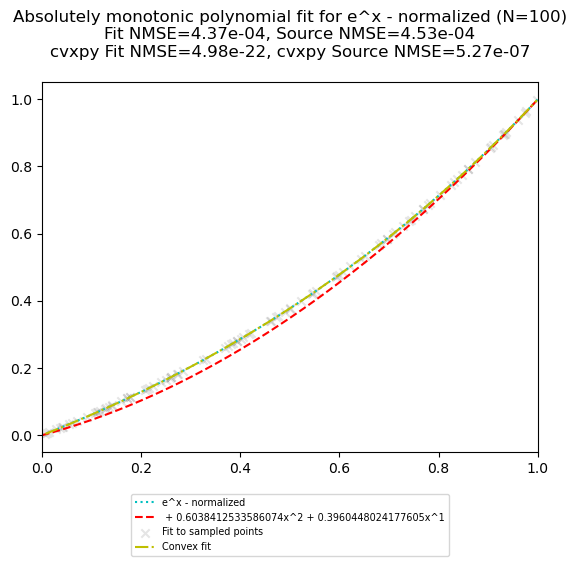

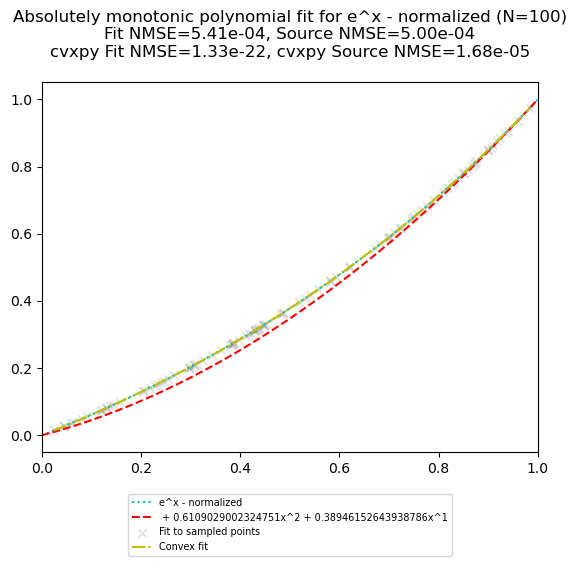

10 tests completed
20 tests completed


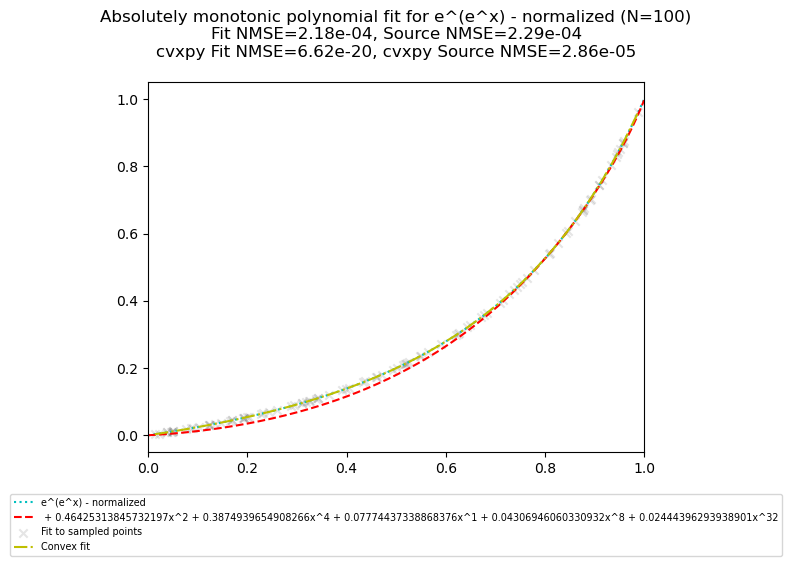

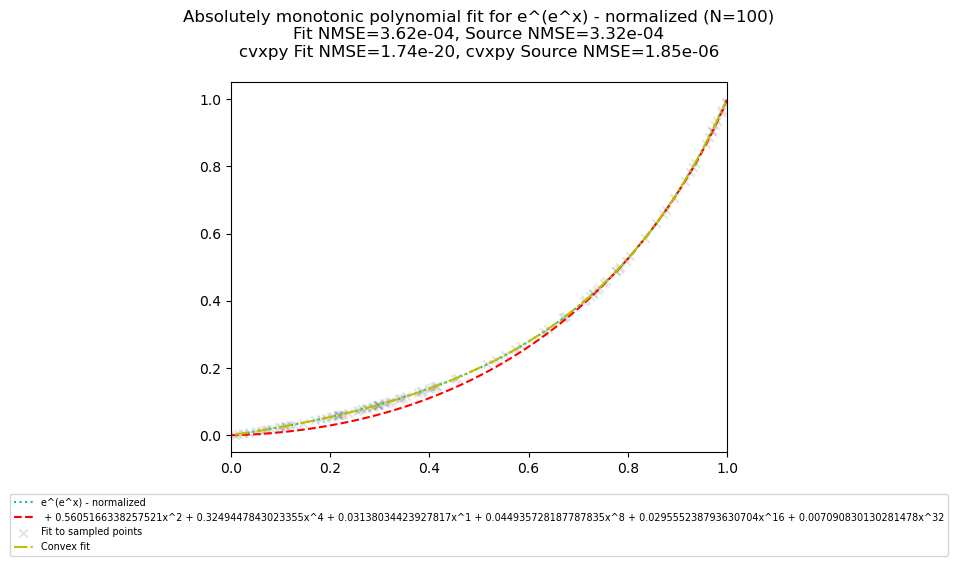

10 tests completed
20 tests completed


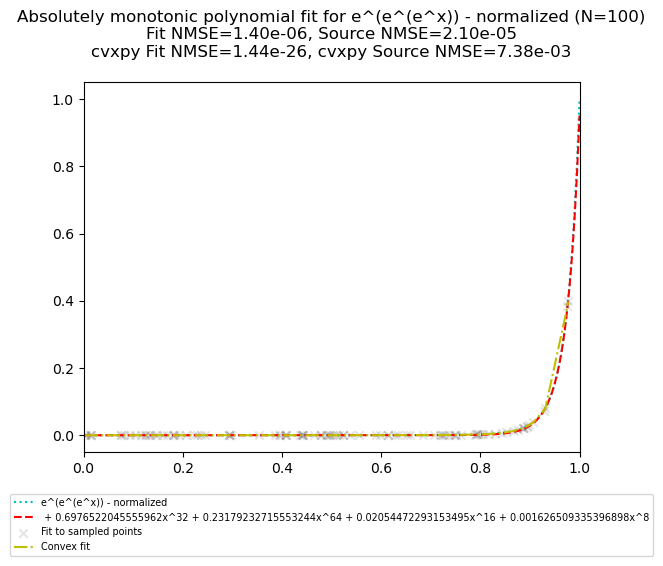

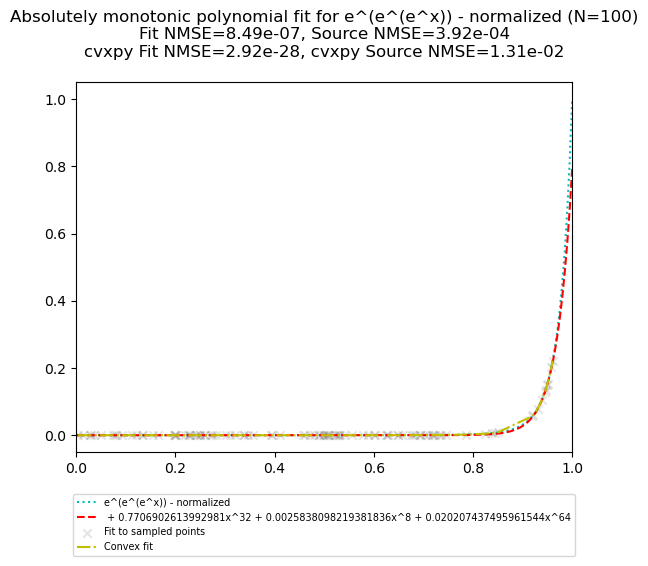

10 tests completed
20 tests completed


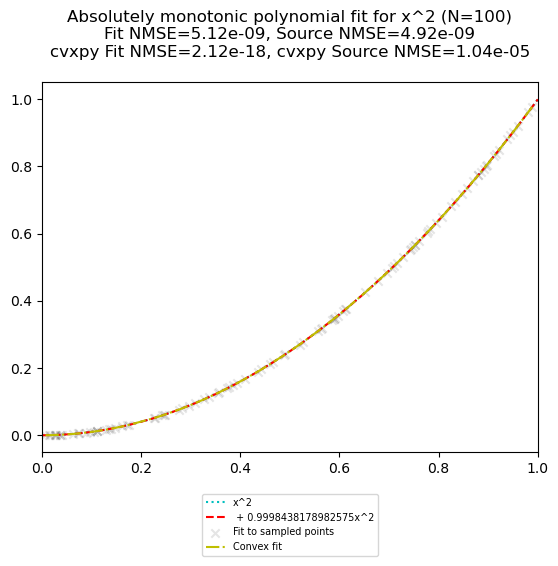

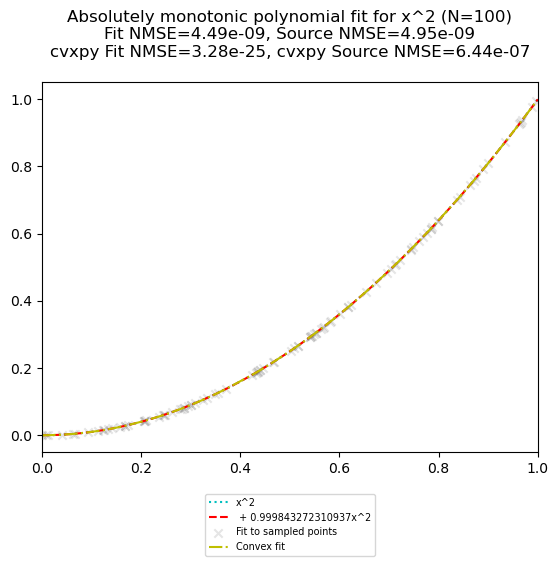

10 tests completed
20 tests completed


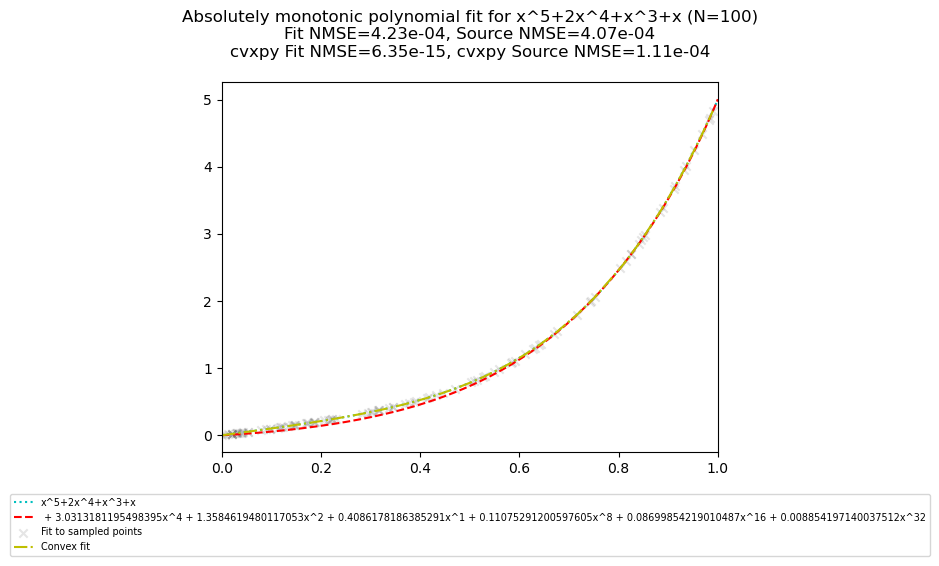

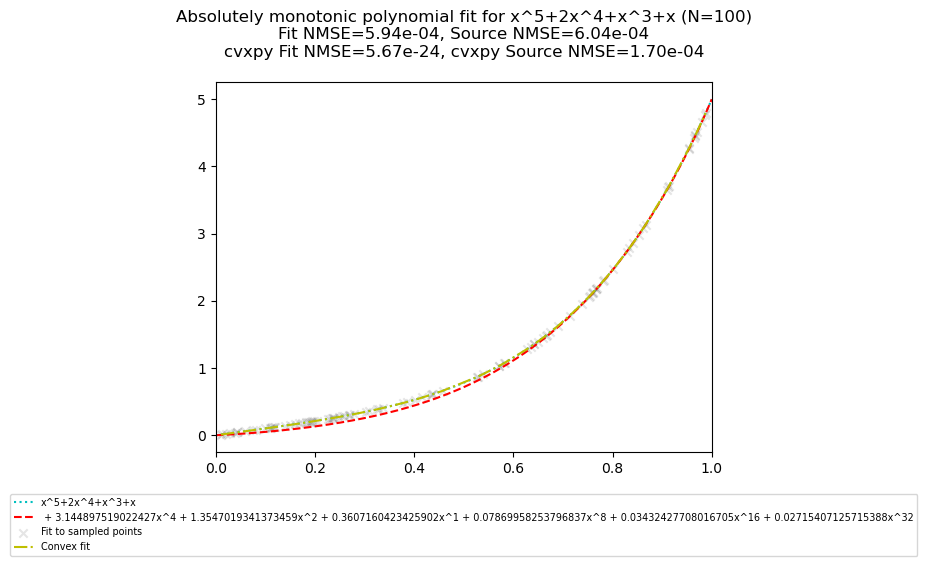

10 tests completed
20 tests completed


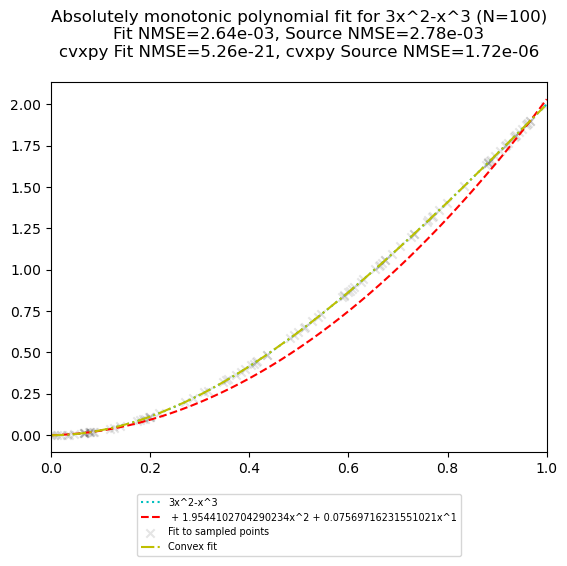

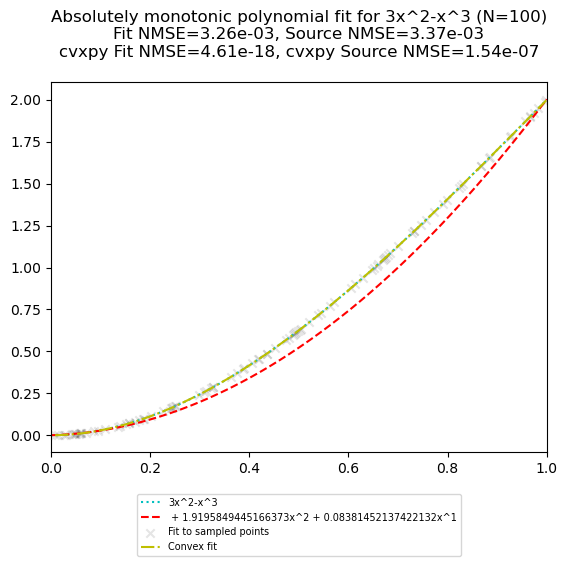

10 tests completed
20 tests completed


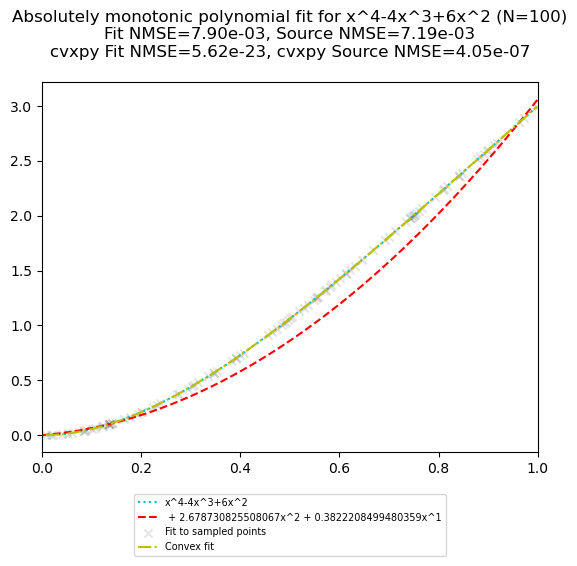

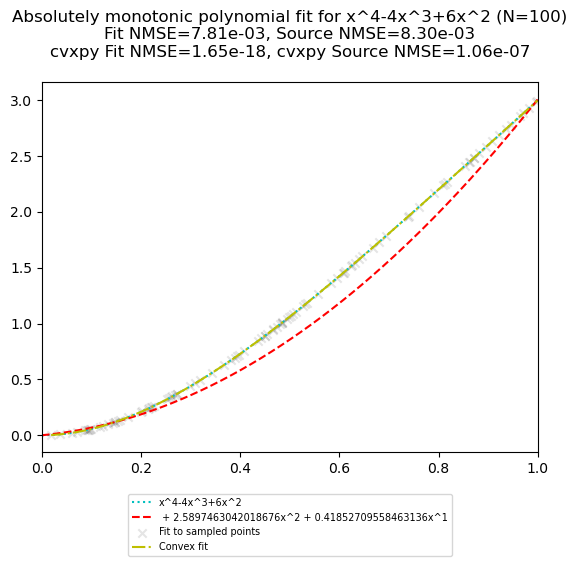

10 tests completed
20 tests completed


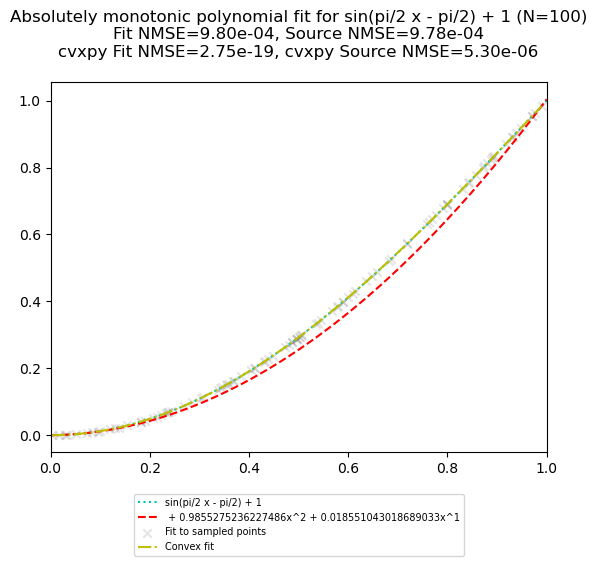

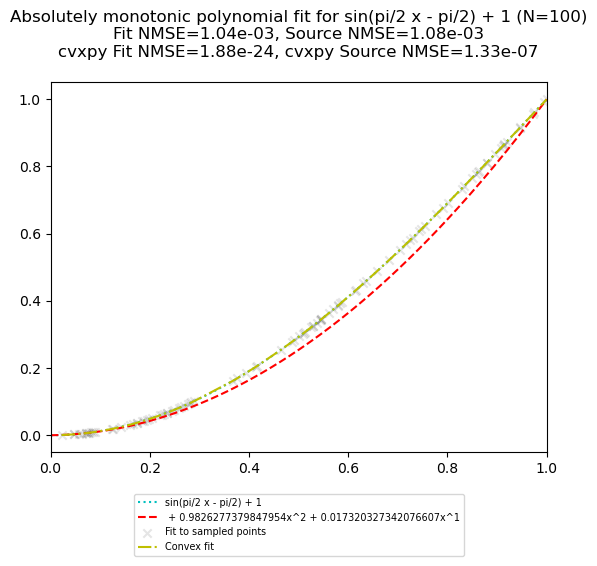

10 tests completed
20 tests completed


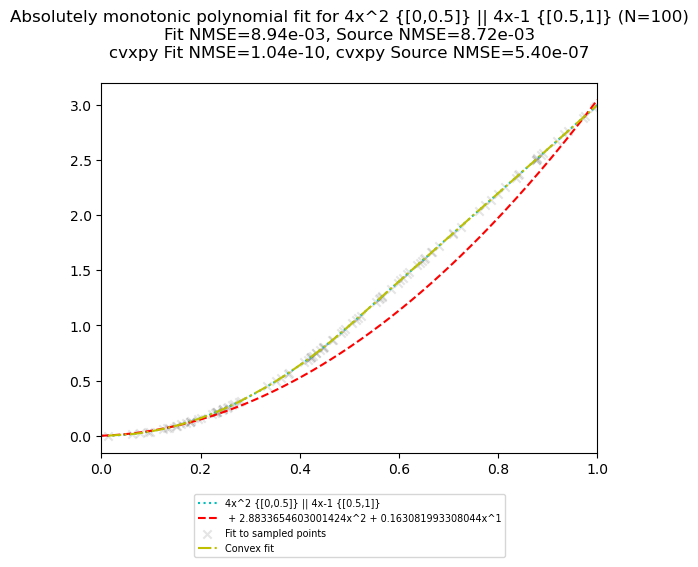

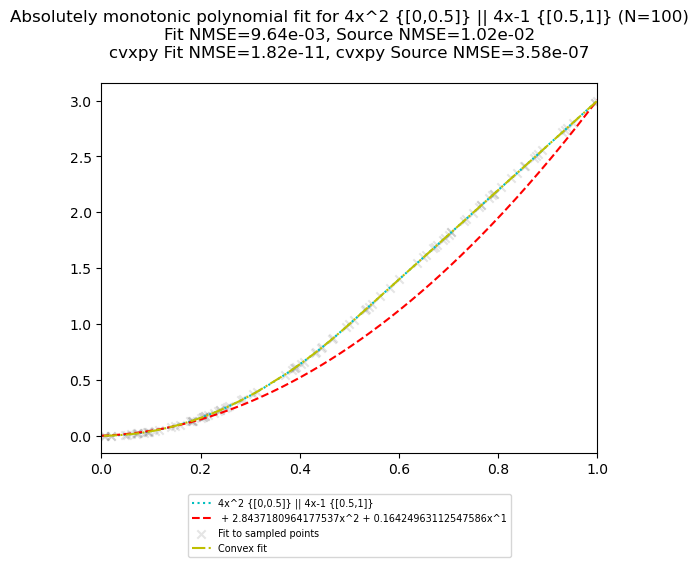

In [116]:
number_samples = 100
number_samples_test=50
number_tests = 20
gaussian_noise_std_mult=0

for (fit_function, function_desc) in functions:
    many_results = monomial_sum_fit_many(fit_function, number_samples, number_tests, gaussian_noise_std_mult=gaussian_noise_std_mult)
    
    avg_result = many_results["avg_result"]
    worst_result = many_results["worst_result"]
    
    plot_full_result_monomial_sum_fit(fit_function, function_desc, number_samples, number_samples_test, gaussian_noise_std_mult, avg_result)
    plot_full_result_monomial_sum_fit(fit_function, function_desc, number_samples, number_samples_test, gaussian_noise_std_mult, worst_result)